In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/25-million-images-0-99757-mnist/MNIST-CNN-ENSEMBLE.csv
/kaggle/input/25-million-images-0-99757-mnist/__results__.html
/kaggle/input/25-million-images-0-99757-mnist/__resultx__.html
/kaggle/input/25-million-images-0-99757-mnist/__notebook__.ipynb
/kaggle/input/25-million-images-0-99757-mnist/__output__.json
/kaggle/input/25-million-images-0-99757-mnist/custom.css
/kaggle/input/25-million-images-0-99757-mnist/__results___files/__results___8_0.png
/kaggle/input/25-million-images-0-99757-mnist/__results___files/__results___5_0.png
/kaggle/input/25-million-images-0-99757-mnist/__results___files/__results___16_0.png
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Indroduction to CNN keras - Acc 0.997 (top 8%)

### Min Chul Cha, PhD

- 1.Introduction
- 2. Data preparation
    - 2.1 Load data
    - 2.2 Check for null and missing values
    - 2.3 Normalization
    - 2.4 Reshape
    - 2.5 Label encoding
    - 2.6 Split training and validation set
- 3. CNN
    - 3.1 Define the model
    - 3.2 Set the optimizer and annealer
    - 3.3 Data augmentation
- 4. Evaluate the model
    - 4.1 Training and validation curves
    - 4.2 Confusion matrix
- 5. Prediction and submission
    - 5.1 Predic and Submit results
    



# 1. Introduction

This ia a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then I will focus on the CNN modeling and evaluation.

I achieved 99.671% of accuracy with this CNN trained in 2h30 on a single CPU (i5 2500k). For those who have a >= 3.0 GPU capabilites (from GTX 650 - to recent GPUs), you can use tensorflow-gpu with keras. Computation will be much much faster!!!

__For computational reason, I set the number of steps (epochs) to 2, if you want to achieve 99+% of accuracy set it to 30.__

This Notebook follows three main parts:

- The data preperation
- The CNN modeling and evaluation
- The results prediction and submission

<img src="https://www.researchgate.net/profile/Hiromichi-Fujisawa/publication/222834590/figure/fig1/AS:305192974209026@1449775083949/Sample-images-of-CENPARMI-data_W640.jpg" ></img>

In [2]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler


sns.set(style='white', context='notebook', palette='deep')



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Data preparation

## 2.1 Load data

In [3]:
# LOAD THE DATA
train = pd.read_csv(f"/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv(f"/kaggle/input/digit-recognizer/test.csv")


In [4]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


The data consists of 1 label + 784 pixel columns (28x28)
The data include grayscale digits from 0 to 255 for each pixel.

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

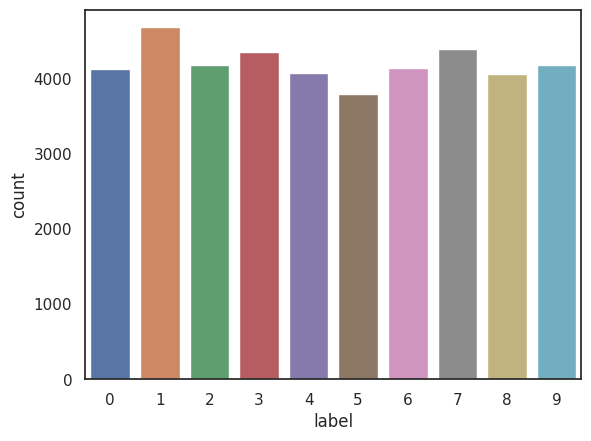

In [5]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop("label", axis = 1)

# free some space
# del train

#g = Y_train.hist()
sns.countplot(data=train, x=train["label"])
plt.show
Y_train.value_counts()

We have similar gounts for the 10 digits.

## 2.2 Check for null and missing values

In [6]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

I check for corrupted images (missing values inside).
There is no missing values in the train and test dataset. So we can safely go ahead.

## 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data then on [0..255].

In [8]:
# Normalization the data
X_train = X_train / 255.0
test = test / 255.0

## 2.4 Reshape

In [9]:
# Reshape image in 3 dimensions (height = 28px, width = 28px, channal = 1)
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

Train and test images (28px X 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images. there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

## 2.5 Label encoding

In [10]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.6 Split training and valdiation set

In [11]:
# Set the random seed
random_seed = 42

#Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use stratify = True option in train_test_split function **(Only for >=0.17 sklearn versions).**

We can get a better sense for one of these examples by visualising the image and looking at the label.

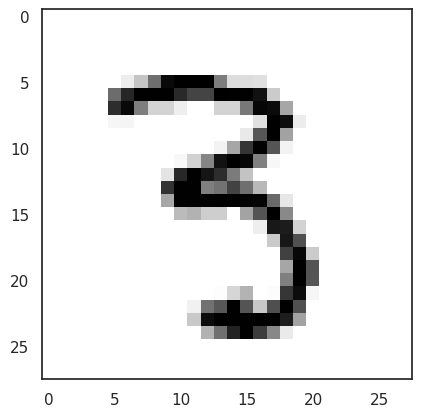

In [12]:
# Some examples
g = plt.imshow(X_train[2][:,:,0], cmap=plt.cm.binary)